In [2]:
import sys
import os

current_dir = os.path.dirname(os.path.abspath(''))
others_path = os.path.join(current_dir, '..', 'gpr')

others_path = os.path.abspath(others_path)
if others_path not in sys.path:
    sys.path.append(others_path)

import numpy as np
import matplotlib.pyplot as plt
from collections.abc import Callable
import cvxpy as cp

from eos import EosProperties
from kernels import Kernel
import gaussianprocess
import finitedimensionalgp as fdgp
import sampling as sam
import prepare_ceft as pc
import prepare_pqcd as pp
import anal_helpers as anal
from pqcd.pQCD import pQCD
from constants import get_phi, ns
import virtobs as vo

from pathlib import Path
notebook_dir = Path.cwd()

from scipy.linalg import cholesky, solve_triangular, cho_solve
from scipy.stats import norm
import scipy as sp
import pandas as pd


from aquarel import load_theme
theme = (
        load_theme("gruvbox_dark")
        .set_font("serif")
        .set_grid(True, width=0.2)
        )

theme.apply()

# the data

In [3]:
grid_size = 400

X_grid = np.geomspace(0.5, 2.0, 40)

n_raw_all = []
cs2_raw_all = []

# Collect all n_raw and cs2_raw
for X in X_grid:
    n_raw, cs2_raw = pp.get_pqcd(X)
    n_raw = n_raw * 0.16  # fm⁻³
    n_raw_all.append(n_raw)
    cs2_raw_all.append(cs2_raw)

# Find global min and max
n_raw_min = min(arr.min() for arr in n_raw_all)
n_raw_max = max(arr.max() for arr in n_raw_all)

n_pqcd_grid = np.linspace(n_raw_min, n_raw_max, grid_size)

# Now interpolate
cs2_family = []
for n_raw, cs2_raw in zip(n_raw_all, cs2_raw_all):
    cs2_interp = np.interp(n_pqcd_grid, n_raw, cs2_raw)
    cs2_family.append(cs2_interp)

cs2_family = np.array(cs2_family)
cs2_min = cs2_family.min(axis=0)
cs2_max = cs2_family.max(axis=0)

mu_pqcd_grid = np.linspace(2.2,3,grid_size)*1000

mu_family = []
for X in X_grid:
    n_raw, cs2_raw = pp.get_pqcd(X, size=grid_size)
    n_raw = n_raw * 0.16                        # convert to fm⁻³
    mu_interp = np.interp(n_pqcd_grid, n_raw, mu_pqcd_grid)
    mu_family.append(mu_interp)

mu_family = np.array(mu_family)               # shape: (n_X, n_n)
mu_min = mu_family.min(axis=0)
mu_max = mu_family.max(axis=0)



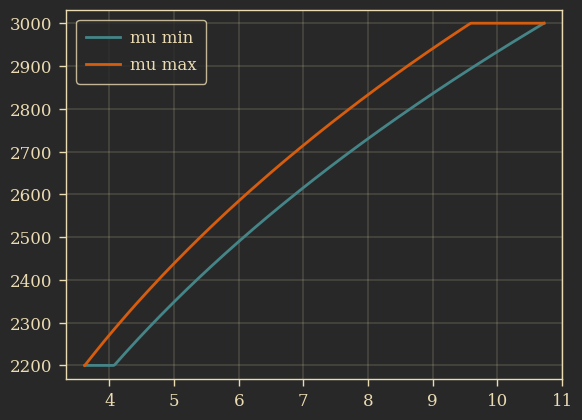

In [4]:
plt.plot(n_pqcd_grid, mu_min, label='mu min')
plt.plot(n_pqcd_grid, mu_max, label='mu max')
plt.legend()

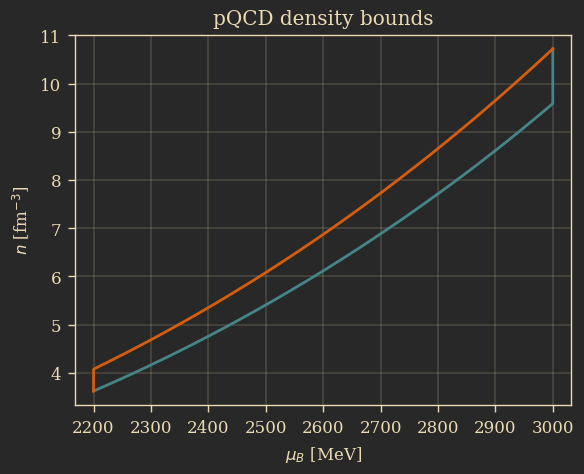

In [5]:
plt.plot(mu_max, n_pqcd_grid)
plt.plot(mu_min, n_pqcd_grid)
plt.xlabel(r'$\mu_B$ [MeV]')
plt.ylabel(r'$n$ [fm$^{-3}$]')
plt.title('pQCD density bounds')
plt.show()

In [37]:
grid_size = 400

X_grid = np.geomspace(0.5, 2.0, 40)

n_raw_all = []
cs2_raw_all = []

mu_pqcd_grid = np.linspace(2.35, 2.75, grid_size) * 1000
mu_raw_all = [mu_pqcd_grid.copy() for _ in X_grid]

# Collect all n_raw and cs2_raw
for X in X_grid:
    n_raw, cs2_raw = pp.get_pqcd(X, size=grid_size, mu_low=2.35, mu_high=2.75)
    n_raw = n_raw * ns  # fm⁻³
    n_raw_all.append(n_raw)
    cs2_raw_all.append(cs2_raw)

# intersection of all n ranges
n_min_common = max(arr.min() for arr in n_raw_all)
n_max_common = min(arr.max() for arr in n_raw_all)
n_pqcd_grid_smaller = np.linspace(n_min_common, n_max_common, grid_size)

# interpolate cs2 and mu onto the common grid
cs2_family, mu_family = [], []
for n_raw, cs2_raw, mu_raw in zip(n_raw_all, cs2_raw_all, mu_raw_all):
    cs2_interp = np.interp(n_pqcd_grid_smaller, n_raw, cs2_raw)
    mu_interp  = np.interp(n_pqcd_grid_smaller, n_raw, mu_raw)
    cs2_family.append(cs2_interp)
    mu_family.append(mu_interp)

cs2_family = np.array(cs2_family)
mu_family  = np.array(mu_family)

cs2_min = cs2_family.min(axis=0)
cs2_max = cs2_family.max(axis=0)
mu_min_smaller  = mu_family.min(axis=0)
mu_max_smaller  = mu_family.max(axis=0)


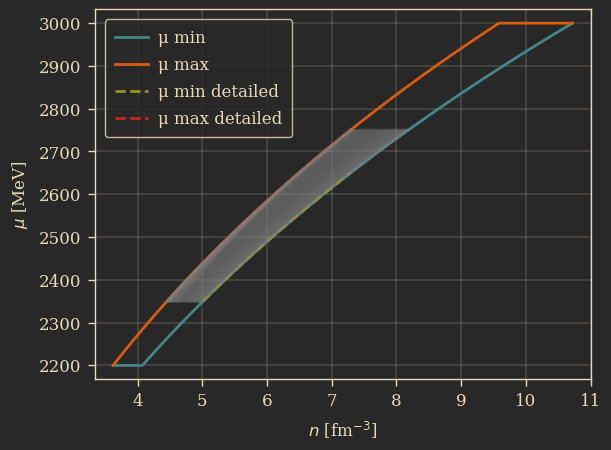

In [38]:
plt.plot(n_pqcd_grid, mu_min, label='μ min')
plt.plot(n_pqcd_grid, mu_max, label='μ max')
plt.plot(n_pqcd_grid_smaller, mu_min_smaller, '--', label='μ min detailed')
plt.plot(n_pqcd_grid_smaller, mu_max_smaller, '--', label='μ max detailed')
for i in range(len(X_grid)):
    plt.plot(n_raw_all[i], mu_raw_all[i], color='gray', alpha=0.3)
plt.xlabel(r"$n$ [fm$^{-3}$]")
plt.ylabel(r"$\mu$ [MeV]")
plt.legend()
plt.show()

In [6]:
n_ceft, cs2_ceft, cs2_l, cs2_u = anal.get_ceft_cs2()
cs2_ceft_sigma = pc.CI_to_sigma(cs2_u-cs2_l)
cs2_hat, X_hat, sigma_hat, l_hat, alpha_hat = sam.get_hype_samples('SE')

l_hat = l_hat*ns
cs2_ceft = cs2_ceft 

n = n_ceft
cs2 = cs2_ceft
cs2_sigma = cs2_ceft_sigma
cs2_ceft_sigma = 1e-2 * np.ones_like(cs2_ceft)

n_pqcd, cs2_pqcd = pp.get_pqcd(X_hat, size=200)
cs2_pqcd_sigma = 1e-2 * np.ones_like(cs2_pqcd)


n = np.concatenate((n, n_pqcd))*ns
cs2 = np.concatenate((cs2, cs2_pqcd))

cs2_sigma = np.concatenate((cs2_ceft_sigma,
                             cs2_pqcd_sigma))

n_test = np.linspace(n[0], 40*ns, 200)

# set up

In [7]:
def softplus(x):
    #return np.maximum(x, 0) + np.log1p(np.exp(-np.abs(x)))
    return np.log1p(np.exp(x))

def log_likelihood_approx(zeta, A, b, eta):
    """
    Approximate log likelihood for linear constraints A zeta + b >= 0
    using a scaled sigmoid function.

    zeta: (d,) current sample
    A: (m, d) constraint matrix
    b: (m,) constraint offset
    eta: approximation strength

    Returns: scalar log likelihood
    """
    logits = A @ zeta + b
    return -np.sum(softplus(-eta * logits))

def sample_prior(cov):
    """
    Sample from N(0, cov)
    """
    return np.random.multivariate_normal(mean=np.zeros(cov.shape[0]), cov=cov)

def project_onto_constraints(A, b, z):
    """
    Project vector z onto the feasible set defined by A x + b >= 0
    using CVXPY with CLARABEL solver.
    Solves: min_x 0.5 * ||x - z||² subject to A x + b >= 0
    """
    d = z.shape[0]
    x = cp.Variable(d)

    objective = cp.Minimize(0.5 * cp.sum_squares(x - z))
    constraints = [A @ x + b >= 0]
    problem = cp.Problem(objective, constraints)
    
    problem.solve(solver=cp.CLARABEL, verbose=False)

    if problem.status not in ["optimal", "optimal_inaccurate"]:
        raise RuntimeError(f"Projection failed: {problem.status}")
    
    return x.value

def elliptical_slice_sampling(f, cov, A, b, eta, log_likelihood_fn, max_attempts=100000):
    nu = sample_prior(cov)
    log_y = log_likelihood_fn(f, A, b, eta) + np.log(np.random.uniform())

    theta = np.random.uniform(0, 2 * np.pi)
    theta_min = theta - 2 * np.pi
    theta_max = theta

    for _ in range(max_attempts):
        f_prime = f * np.cos(theta) + nu * np.sin(theta)
        ll = log_likelihood_fn(f_prime, A, b, eta)

        if ll > log_y:
            print(f"θ: {theta:.2f}, log_y: {log_y:.2f}, log_ll: {ll:.2f}, min_constraint: {np.min(A @ f_prime + b):.4f}")

            violation = A @ f_prime + b
            if np.all(violation >= 0):
                return f_prime
            elif np.min(violation) > -1e-6:
                # Mild violation → likely due to approximation → project
                try:
                    projected = project_onto_constraints(A, b, f_prime)
                    return projected
                except RuntimeError:
                    print("Projection failed")
                    continue

            # Else: do not accept — continue slicing
        # Not accepted: shrink bracket
        if theta < 0:
            theta_min = theta
        else:
            theta_max = theta
        theta = np.random.uniform(theta_min, theta_max)

    raise RuntimeError("ESS failed to find valid sample after max_attempts.")

def sample_tmvn_ess(mu, cov, A, b, X, y, n_samples, burn_in=100, eta_init=20.0, update_eta=False):
    d = mu.shape[0]
    zeta = mu.copy()
    samples = []
    eta = eta_init
    count = 0

    while len(samples) < n_samples:
        zeta_centered = zeta - mu
        zeta_centered = elliptical_slice_sampling(
            f=zeta_centered,
            cov=cov,
            A=A,
            b=b,
            eta=eta,
            log_likelihood_fn=lambda z, *_: log_likelihood_approx(z, A, b, eta)
        )
        zeta = zeta_centered + mu
        if np.all(A @ zeta + b >= 0):
            samples.append(zeta.copy())

        if update_eta:
            eta *= 1.01

        if count > n_samples + 10:
            raise ValueError("Max iterations reached")
        count += 1
    samples = np.array(samples)
    samples = samples[burn_in:]
    return samples

def sample_posterior(self, init, n_samples, eta=20, burn_in=1000, update_eta=True):
    mu = init
    cov = np.linalg.inv(self.cov_star_inverse)
    A = self.constraints["M"]
    b = self.constraints["g"]
    X = self.Phi_matrix  # assume you store design matrix in self.X
    y = self.y_train  # assume targets are in self.y

    samples = sample_tmvn_ess(mu, cov, A, b, X, y, n_samples + burn_in, eta_init=eta, update_eta=update_eta)
    return samples[burn_in:]

# testing it

In [8]:
import virtobs as vo

from virtobs import LinearOperator, Constraint

In [9]:
kern = Kernel("SE", sigma=sigma_hat, l=l_hat*ns)

vogp_noconstraint = vo.VOGP(
    kernel=kern,
    x_train=n,
    y_train= cs2,
    x_test=n_test,
    var_y=cs2_sigma,
    stabilise=True
)


In [10]:
vogp_noconstraint.fit()

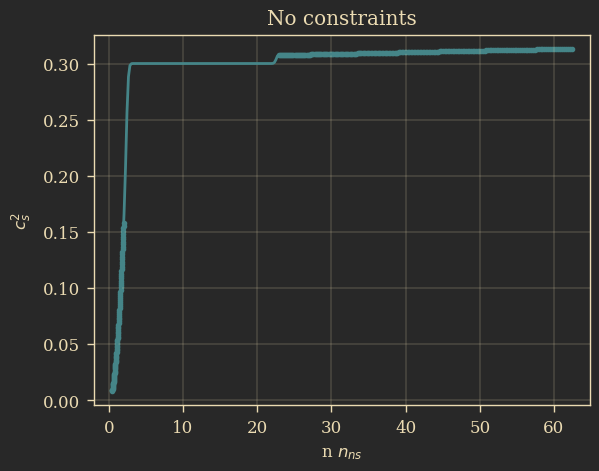

In [11]:
plt.plot(n_test/ns, vogp_noconstraint.mean_star, label='GP pred')
plt.scatter(n/ns, cs2, label='Data', marker='.')
plt.xlabel(r"n $n_{ns}$")
plt.ylabel(r"$c_s^2$")
plt.title("No constraints")
plt.show()
theme.apply_transforms()

In [12]:
class BoundOperator(LinearOperator):
    """"
    Identity operator as constraint is a<=f(x)<=b
    
    L[f](x) = f(x)
    """
    def apply_mean(self, mu):
        return mu
    
    def K_with_f(self, kern, X_op, X_f):
        return kern.compute(X_op, X_f)

    def K_with_L(self, kern, X_op1, op2, X_op2):
        return kern.compute(X_op1, X_op2)

In [13]:
LB = lambda x: np.zeros(x.shape[0])      # Lower bound: 0
UB = lambda x: np.ones(x.shape[0])  # Upper bound: 1

In [14]:
op = BoundOperator()
box_constraint = Constraint(op, LB, UB)

xv = np.linspace(0.16, 8, 5).reshape(-1, 1) # virtual points
box_constraint.add(xv)

vogp = vo.VOGP(
    kernel=kern,
    x_train=n,
    y_train=cs2,
    x_test=n_test,
    var_y=cs2_sigma,
    constraints=[box_constraint],
    stabilise=True,
    jitter_value=1e-8,
    var_constr=1e-4
)

In [15]:
vogp.fit_constrained(n_samples=1)

ValueError: The matrix K_11 probably is not semi-positive definite. Using a jitter value (set stabilise=True), or increasing it (default jitter_value=1e-10) can help with numerical stability.

In [ ]:
term_a = vogp.A1 @ vogp.tester

In [42]:
v1 = cho_solve((vogp.L, True), vogp.tester, check_finite=False)
term_b = v1.T@v1

In [43]:
term_a-term_b

array([[ 5.03296178e-08,  4.41762107e-27,  3.18513589e-64,
        -2.23811901e-66, -1.09343788e-69],
       [-5.44932492e-25,  2.58844985e-31,  1.22312902e-18,
        -1.64064004e-20, -7.49581943e-23],
       [-1.23157235e-69, -8.27180613e-25, -1.36624045e-12,
        -1.96881682e-13, -8.68381904e-15],
       [-7.19926487e-70, -2.04371772e-25,  4.51646424e-13,
        -3.70173336e-12,  4.34597508e-13],
       [ 1.37427005e-71,  3.27661266e-26,  3.32081977e-15,
        -2.35025215e-14,  2.82507351e-12]])

In [44]:
term_a

array([[ 9.14493836e+03,  1.59167179e-13, -1.79970584e-55,
         3.26645194e-57,  1.18401957e-58],
       [ 1.59167179e-13,  5.77590659e-17, -5.85957971e-10,
         5.55748566e-12,  3.43627848e-13],
       [-1.79970585e-55, -5.85957972e-10,  2.21187167e-01,
         6.05690854e-04,  1.29116618e-05],
       [ 3.26645194e-57,  5.55748567e-12,  6.05690855e-04,
         2.45928158e-01, -7.56840105e-05],
       [ 1.18401957e-58,  3.43627848e-13,  1.29116618e-05,
        -7.56840110e-05,  2.94691648e-01]])

In [45]:
term_b

array([[ 9.14493836e+03,  1.59167179e-13, -1.79970585e-55,
         3.26645194e-57,  1.18401957e-58],
       [ 1.59167179e-13,  5.77590659e-17, -5.85957972e-10,
         5.55748567e-12,  3.43627848e-13],
       [-1.79970585e-55, -5.85957972e-10,  2.21187167e-01,
         6.05690854e-04,  1.29116618e-05],
       [ 3.26645194e-57,  5.55748567e-12,  6.05690854e-04,
         2.45928158e-01, -7.56840109e-05],
       [ 1.18401957e-58,  3.43627848e-13,  1.29116618e-05,
        -7.56840109e-05,  2.94691648e-01]])

In [46]:
vogp.tester1 + term_b - term_a

array([[-9.14318446e+03, -1.59109535e-13,  1.79970584e-55,
        -3.26645194e-57, -1.18401957e-58],
       [-1.59109535e-13,  1.75390177e+00,  5.85958028e-10,
        -5.55748566e-12, -3.43627848e-13],
       [ 1.79970585e-55,  5.85958029e-10,  1.53271460e+00,
        -6.05690854e-04, -1.29116618e-05],
       [-3.26645194e-57, -5.55748567e-12, -6.05690855e-04,
         1.50797361e+00,  7.56840105e-05],
       [-1.18401957e-58, -3.43627848e-13, -1.29116618e-05,
         7.56840110e-05,  1.45921012e+00]])

In [47]:
v2 = cho_solve((vogp.L,True), vogp.K_x_xs)
B2_1 = vogp.K_xs_xs - v2.T@v2

In [48]:
B2_1

array([[ 1.15218625e+00,  1.61823158e+00, -3.42844576e+00, ...,
         4.97659753e-64,  8.01313404e-64,  5.60640385e-64],
       [ 1.61823158e+00, -2.36178393e-01, -1.85811694e+01, ...,
        -8.27839139e-62, -2.56402491e-62,  4.08537418e-62],
       [-3.42844576e+00, -1.85811694e+01, -2.34158055e+02, ...,
        -4.90599998e-60, -1.47009598e-60,  2.48261131e-60],
       ...,
       [ 4.97659753e-64, -8.27839139e-62, -4.90599998e-60, ...,
         1.50019019e+00,  1.50922467e+00,  1.52793706e+00],
       [ 8.01313404e-64, -2.56402491e-62, -1.47009598e-60, ...,
         1.50922467e+00,  1.49936391e+00,  1.50848245e+00],
       [ 5.60640385e-64,  4.08537418e-62,  2.48261131e-60, ...,
         1.52793706e+00,  1.50848245e+00,  1.49853951e+00]])

In [49]:
vogp._compute_cholesky(vogp.tester1, f=None, only_L=True)

ValueError: The matrix K_11 probably is not semi-positive definite. Using a jitter value (set stabilise=True), or increasing it (default jitter_value=1e-10) can help with numerical stability.

In [50]:
vogp._compute_cholesky(vogp.tester1 + term_b - term_a, f=None, only_L=True)

ValueError: The matrix K_11 probably is not semi-positive definite. Using a jitter value (set stabilise=True), or increasing it (default jitter_value=1e-10) can help with numerical stability.

In [ ]:
v = cho_solve((vogp.L, True),vogp._calc_L2T(vogp.X))

In [52]:
(v.T@v)

NameError: name 'v' is not defined

In [53]:
L_Kx_xv_LT = vogp._calc_L1L2()


In [ ]:
L_Kx_xv_LT

array([[1.39973688e+000, 8.29861430e-069, 1.72935083e-273,
        0.00000000e+000, 0.00000000e+000],
       [8.29861430e-069, 1.39973688e+000, 8.29861430e-069,
        1.72935083e-273, 0.00000000e+000],
       [1.72935083e-273, 8.29861430e-069, 1.39973688e+000,
        8.29861430e-069, 1.72935083e-273],
       [0.00000000e+000, 1.72935083e-273, 8.29861430e-069,
        1.39973688e+000, 8.29861430e-069],
       [0.00000000e+000, 0.00000000e+000, 1.72935083e-273,
        8.29861430e-069, 1.39973688e+000]])

In [ ]:
L1L2T_K_xv_xv = kern.compute(xv, xv)

In [ ]:
# this is the L (K_xv_xv) L.T
K_manual = kern.compute(xv, xv)
K_func = vogp._calc_L1L2()

In [ ]:
print("Manual kernel:\n", K_manual)
print("From _calc_L1L2:\n", K_func)
print("Difference:\n", K_manual - K_func)
print("Max abs diff:", np.max(np.abs(K_manual - K_func)))

Manual kernel:
 [[1.39973688e+000 8.29861430e-069 1.72935083e-273 0.00000000e+000
  0.00000000e+000]
 [8.29861430e-069 1.39973688e+000 8.29861430e-069 1.72935083e-273
  0.00000000e+000]
 [1.72935083e-273 8.29861430e-069 1.39973688e+000 8.29861430e-069
  1.72935083e-273]
 [0.00000000e+000 1.72935083e-273 8.29861430e-069 1.39973688e+000
  8.29861430e-069]
 [0.00000000e+000 0.00000000e+000 1.72935083e-273 8.29861430e-069
  1.39973688e+000]]
From _calc_L1L2:
 [[1.39973688e+000 8.29861430e-069 1.72935083e-273 0.00000000e+000
  0.00000000e+000]
 [8.29861430e-069 1.39973688e+000 8.29861430e-069 1.72935083e-273
  0.00000000e+000]
 [1.72935083e-273 8.29861430e-069 1.39973688e+000 8.29861430e-069
  1.72935083e-273]
 [0.00000000e+000 1.72935083e-273 8.29861430e-069 1.39973688e+000
  8.29861430e-069]
 [0.00000000e+000 0.00000000e+000 1.72935083e-273 8.29861430e-069
  1.39973688e+000]]
Difference:
 [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
Max abs di

In [ ]:
# this is K_(x,xv) L.T

K_manual_1 = kern.compute(vogp.X, box_constraint.Xv)  # shape (n_train, n_xv)
K_func_1 = vogp._calc_L2T(vogp.X)                    # shape (n_train, n_xv)

print("Manual kernel:\n", K_manual_1)
print("From _calc_L2T:\n", K_func_1)
print("Difference:\n", K_manual_1 - K_func_1)
print("Max abs diff:", np.max(np.abs(K_manual_1 - K_func_1)))

Manual kernel:
 [[5.69494215e-001 1.60098908e-079 1.58199744e-294 0.00000000e+000
  0.00000000e+000]
 [5.72252552e-001 1.71498047e-079 1.80654577e-294 0.00000000e+000
  0.00000000e+000]
 [5.75016765e-001 1.83706419e-079 2.06293958e-294 0.00000000e+000
  0.00000000e+000]
 ...
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  1.79298757e-110]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  2.15229881e-114]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  2.14918481e-118]]
From _calc_L2T:
 [[5.69494215e-001 1.60098908e-079 1.58199744e-294 0.00000000e+000
  0.00000000e+000]
 [5.72252552e-001 1.71498047e-079 1.80654577e-294 0.00000000e+000
  0.00000000e+000]
 [5.75016765e-001 1.83706419e-079 2.06293958e-294 0.00000000e+000
  0.00000000e+000]
 ...
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  1.79298757e-110]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
  2.15229881e-114]
 [0.00000000e+000 0.0

In [ ]:
v_func = cho_solve((vogp.L, True),K_func_1)
v_manual = cho_solve((vogp.L, True),K_manual_1)

vTv_func = v_func.T @ v_func
vTv_manual = v_manual.T @ v_manual 

print("Manual vTv:\n", vTv_manual)
print("From _calc_L2T:\n", vTv_func)
print("Difference:\n", vTv_manual - vTv_func)
print("Max abs diff:", np.max(np.abs(vTv_manual - vTv_func)))

Manual vTv:
 [[ 3.45406778e+003  7.63025388e-071 -2.31341787e-258 -3.05673961e-261
   5.49439556e-266]
 [ 7.63025388e-071  1.78731612e-115 -1.15316075e-059 -1.61811171e-062
   2.12342950e-067]
 [-2.31341787e-258 -1.15316075e-059  4.43464008e-001  1.21759983e-005
   1.91488799e-009]
 [-3.05673961e-261 -1.61811171e-062  1.21759983e-005  4.84501363e-001
  -8.36331232e-006]
 [ 5.49439556e-266  2.12342950e-067  1.91488799e-009 -8.36331232e-006
   5.80618928e-001]]
From _calc_L2T:
 [[ 3.45406778e+003  7.63025388e-071 -2.31341787e-258 -3.05673961e-261
   5.49439556e-266]
 [ 7.63025388e-071  1.78731612e-115 -1.15316075e-059 -1.61811171e-062
   2.12342950e-067]
 [-2.31341787e-258 -1.15316075e-059  4.43464008e-001  1.21759983e-005
   1.91488799e-009]
 [-3.05673961e-261 -1.61811171e-062  1.21759983e-005  4.84501363e-001
  -8.36331232e-006]
 [ 5.49439556e-266  2.12342950e-067  1.91488799e-009 -8.36331232e-006
   5.80618928e-001]]
Difference:
 [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 

In [ ]:
B1_manual = K_manual - vTv_manual
B1_func = K_func - vTv_func

print("B1 manual:\n", B1_manual)
print("B1 from _calc_L2T:\n", B1_func)
print("B1 difference:\n", B1_manual - B1_func)
print("B1 max abs diff:", np.max(np.abs(B1_manual - B1_func)))

B1 manual:
 [[-3.45266804e+003  8.22231176e-069  2.31341787e-258  3.05673961e-261
  -5.49439556e-266]
 [ 8.22231176e-069  1.39973688e+000  1.15316075e-059  1.61811171e-062
  -2.12342950e-067]
 [ 2.31341787e-258  1.15316075e-059  9.56272869e-001 -1.21759983e-005
  -1.91488799e-009]
 [ 3.05673961e-261  1.61811171e-062 -1.21759983e-005  9.15235514e-001
   8.36331232e-006]
 [-5.49439556e-266 -2.12342950e-067 -1.91488799e-009  8.36331232e-006
   8.19117949e-001]]
B1 from _calc_L2T:
 [[-3.45266804e+003  8.22231176e-069  2.31341787e-258  3.05673961e-261
  -5.49439556e-266]
 [ 8.22231176e-069  1.39973688e+000  1.15316075e-059  1.61811171e-062
  -2.12342950e-067]
 [ 2.31341787e-258  1.15316075e-059  9.56272869e-001 -1.21759983e-005
  -1.91488799e-009]
 [ 3.05673961e-261  1.61811171e-062 -1.21759983e-005  9.15235514e-001
   8.36331232e-006]
 [-5.49439556e-266 -2.12342950e-067 -1.91488799e-009  8.36331232e-006
   8.19117949e-001]]
B1 difference:
 [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 

In [ ]:
L1_manual = cholesky(B1_manual, lower=True)


LinAlgError: 1-th leading minor of the array is not positive definite

In [ ]:
eigvals = np.linalg.eigvalsh(B1_manual)
print("Eigenvalues:", eigvals)
print("Min eigenvalue:", np.min(eigvals))

Eigenvalues: [-3.45266804e+03  8.19117948e-01  9.15235511e-01  9.56272873e-01
  1.39973688e+00]
Min eigenvalue: -3452.668040871082


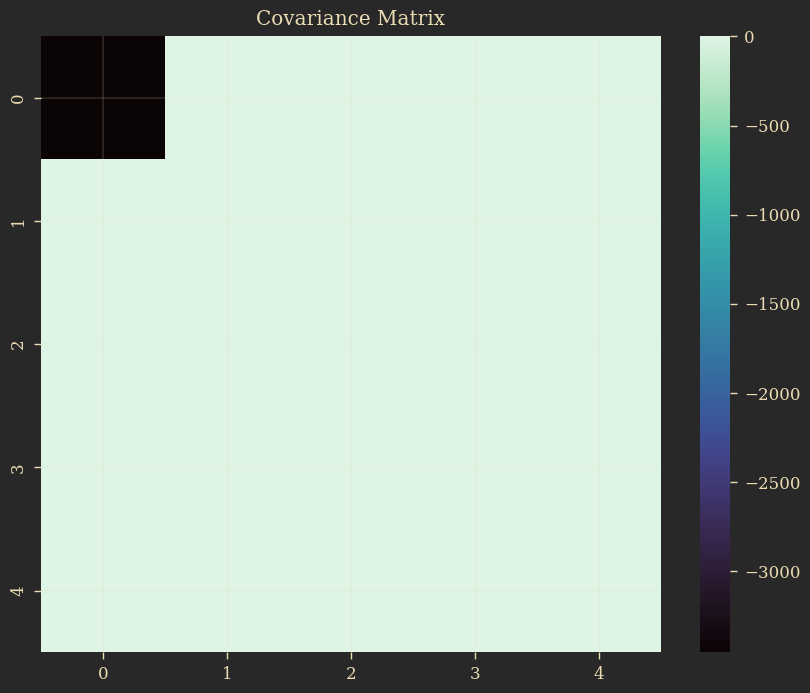

In [ ]:
kern.visualise_kernel(B1_manual, annotation=False)

In [ ]:
smthng = vogp.find_XV_subop(p_target=1e-4, bounds=[(0.4,5)])

RuntimeError: The map-like callable must be of the form f(func, iterable), returning a sequence of numbers the same length as 'iterable'

# in Agrell's code, he had something to repair the cholesky decomposition, maybe i should try that too

# veiga and marrel

In [16]:
kernel = Kernel('SE', sigma=sigma_hat, l=l_hat)


gp = gaussianprocess.GP(kernel, cs2_hat)
gp.fit(n, n_test, f = cs2, var_f = cs2_sigma, stabilise=True)

cs2_test, sig = gp.posterior(sampling=False)

## only bounded

In [17]:
import numpy as np

# Assume we have these from before:
# x_train, y_train, x_test, y_test
# gp is your fitted GP object

# Step 1: choose constraint locations (discretization of I)
X_c = np.linspace(n[0], n[-1], 400)  # for prototyping, uniform grid
a = np.zeros(len(X_c))     # lower bound 0
b = np.ones(len(X_c))      # upper bound 1

# Step 2: compute GP posterior mean and cov at constraint points
# (like the GP.predict step but for X_c instead of X_test)
mean_train, mean_c = gp._set_means(n, X_c)
K_11, K_1c, K_cc = gp._set_kernels(n, X_c, var_f=None, stabilise=True)

f_tilde = cs2 - mean_train
L, alpha = gp._compute_cholesky(K_11, f_tilde)

mu_Z = mean_c + (K_1c.T @ alpha)                      # E[Ỹ(X_c)]
v_c = solve_triangular(L, K_1c, lower=True, check_finite=False)
Sigma_Z = K_cc - (v_c.T @ v_c)                        # Cov[Ỹ(X_c)]


In [18]:
# covariance between test points and constraint points
K_1t, K_tc = gp.kernel.compute(n, n_test), gp.kernel.compute(n_test, X_c)
mean_train, mean_test = gp._set_means(n, n_test)

# conditional cross-covariance: k(x_*, X_c) - k(X_s, x_*)^T Σ_s^{-1} k(X_s, X_c)
# k(X_s, x_*)^T Σ_s^{-1} k(X_s, X_c) = k(X_s, x_*)^T (L L^T)^{-1} k(X_s, X_c) = (L^{-1} k(X_s, x_*))^T (L^{-1} k(X_s, X_c))
v_t = solve_triangular(L, K_1t, lower=True, check_finite=False) # (L^{-1} k(X_s, x_*))^T 
v_c = solve_triangular(L, K_1c, lower=True, check_finite=False) #  (L^{-1} k(X_s, X_c))
K_tt = gp.kernel.compute(n_test)

Sigma_YZ = K_tc - v_t.T @ v_c   # Cov(Ỹ(x_*), Ỹ(X_c))


In [19]:
mu_W = np.concatenate([gp.mean_star.ravel(), mu_Z.ravel()])
Sigma_W = np.block([
    [gp.cov_star,            Sigma_YZ],
    [Sigma_YZ.T,             Sigma_Z]
])


In [20]:
import tmg_samplers as tmg

d = len(mu_Z)
A = np.vstack([np.eye(d), -np.eye(d)])
b_vec = np.concatenate([-a, b])
# mean and covariance from Step 2:
mu = mu_Z
cov = Sigma_Z

# build constraint matrices
d = len(mu)
A = np.vstack([np.eye(d), -np.eye(d)])
b_vec = np.concatenate([-a, b])

In [21]:
# draw samples
Z_samples = tmg.sample_tmvn_ess(mu, cov, A, b_vec, X=None, y=None, n_samples=50, update_eta=True)


In [22]:
# compute truncated moments
nu_Z = np.mean(Z_samples, axis=0)
Gamma_Z = np.cov(Z_samples, rowvar=False)


### sanity checks

In [23]:
print(np.all(Z_samples >= a - 1e-8))
print(np.all(Z_samples <= b + 1e-8))


True
True


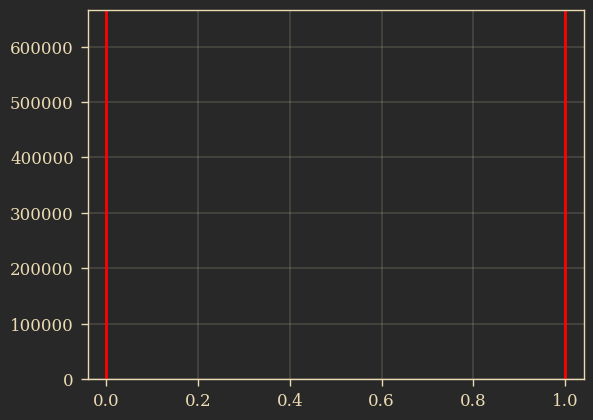

In [24]:
import matplotlib.pyplot as plt
plt.hist(Z_samples[:,0], bins=50, density=True)
plt.axvline(a[0], color='red')
plt.axvline(b[0], color='red')


In [25]:
print("ν_Z mean range:", Z_samples.mean(axis=0).min(), Z_samples.mean(axis=0).max())
print("Fraction of samples at upper bound:", np.mean(Z_samples > 0.9999))


ν_Z mean range: 0.00807513567609183 0.810504532940352
Fraction of samples at upper bound: 0.0


dist_to_bound quantiles: [0.00807262 0.30796226 0.30914392 0.31151039 0.35628069 0.36633538
 0.4983547 ]


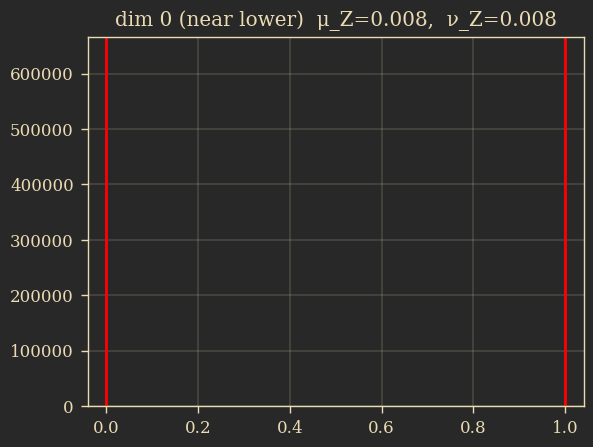

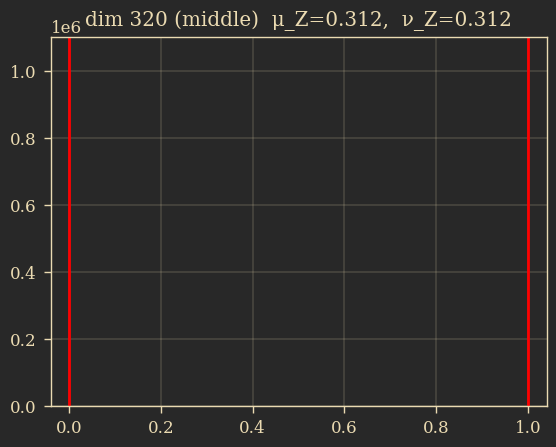

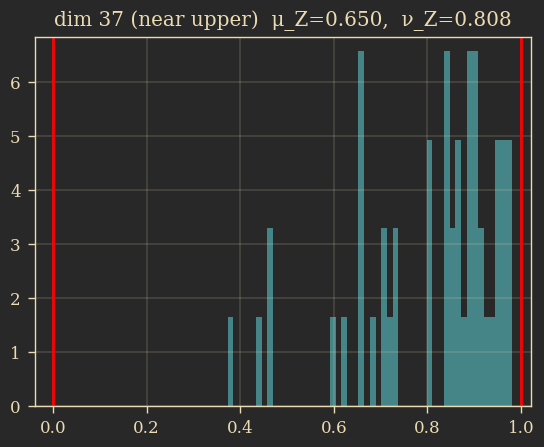

In [26]:
# 1) How close each constraint component's unconstrained mean is to the nearest bound
dist_to_bound = np.minimum(mu_Z, 1 - mu_Z)            # shape (n_c,)
print("dist_to_bound quantiles:",
      np.quantile(dist_to_bound, [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0]))

# 2) Pick three representative indices
near_lower = np.argmin(mu_Z)                          # closest to 0
near_upper = np.argmax(mu_Z)                          # closest to 1
mid_idx    = np.argsort(dist_to_bound)[len(dist_to_bound)//2]  # most 'central'

# 3) Plot marginals for those three dims
import matplotlib.pyplot as plt

for j, title in [(near_lower, "near lower"), (mid_idx, "middle"), (near_upper, "near upper")]:
    plt.figure()
    plt.hist(Z_samples[:, j], bins=50, density=True)
    plt.axvline(0, color='red'); plt.axvline(1, color='red')
    plt.title(f"dim {j} ({title})  μ_Z={mu_Z[j]:.3f},  ν_Z={Z_samples[:,j].mean():.3f}")
    plt.show()


### step 4

In [27]:
import numpy as np
from scipy.linalg import cholesky, solve_triangular

def constrained_gp_update(mean_star, cov_star,
                          mu_Z, Sigma_Z, Sigma_YZ,
                          nu_Z, Gamma_Z, jitter=1e-10):
    """
    Implements eqs. (15)-(16) using Cholesky solves.

    Shapes:
      mean_star: (n_t,)
      cov_star:  (n_t, n_t)
      mu_Z:      (n_c,)
      Sigma_Z:   (n_c, n_c)
      Sigma_YZ:  (n_t, n_c)
      nu_Z:      (n_c,)
      Gamma_Z:   (n_c, n_c)
    """
    n_t, n_c = Sigma_YZ.shape
    assert Sigma_Z.shape == (n_c, n_c)
    assert Gamma_Z.shape == (n_c, n_c)

    # Small symmetrization (sampling noise) and jitter for Σ_Z
    Gamma_Z = 0.5 * (Gamma_Z + Gamma_Z.T)
    Sigma_Z = 0.5 * (Sigma_Z + Sigma_Z.T) + jitter * np.eye(n_c)

    # Cholesky Σ_Z = L L^T
    Lz = cholesky(Sigma_Z, lower=True, check_finite=False)
    # Helper: solve Σ_Z x = B  via two triangular solves
    def solve_Sz(B):
        # Solve Lz y = B
        y = solve_triangular(Lz, B, lower=True, check_finite=False)
        # Solve Lz^T x = y
        x = solve_triangular(Lz.T, y, lower=False, check_finite=False)
        return x

    # ===== Mean update =====
    delta = nu_Z - mu_Z                              # (n_c,)
    a = solve_Sz(delta)                              # a = Σ_Z^{-1} (ν_Z - μ_Z) (n_c,)
    mu_con = mean_star + Sigma_YZ @ a                # (n_t,)
    # ===== Variance update =====
    # term1 = Σ_YZ Σ_Z^{-1} Σ_YZ^T
    S1 = solve_Sz(Sigma_YZ.T)                        # (n_c, n_t)  = Σ_Z^{-1} Σ_YZ^T
    term1 = Sigma_YZ @ S1                            # (n_t, n_t)

    # term2 = Σ_YZ Σ_Z^{-1} Γ_Z Σ_Z^{-1} Σ_YZ^T
    T = solve_Sz(Gamma_Z)                            # (n_c, n_c)  = Σ_Z^{-1} Γ_Z
    term2 = Sigma_YZ @ (T @ S1)                      # (n_t, n_t)
    cov_con = cov_star - term1 + term2
    print(a.shape)
    print(T.shape)
    print(term1.shape)
    print(term2.shape)
    print(cov_star.shape)
    # Symmetrize (numerics)
    cov_con = 0.5 * (cov_con + cov_con.T)

    return mu_con, cov_con

# --- use it with your variables from previous steps ---
mu_con, cov_con = constrained_gp_update(
    mean_star=gp.mean_star.ravel(),
    cov_star=gp.cov_star,
    mu_Z=mu_Z, Sigma_Z=Sigma_Z, Sigma_YZ=Sigma_YZ,
    nu_Z=nu_Z, Gamma_Z=Gamma_Z, jitter=1e-10
)

# For plotting like your GP.posterior() output:
sig_con = np.sqrt(np.clip(np.diag(cov_con), 0, np.inf))


(400,)
(400, 400)
(200, 200)
(200, 200)
(200, 200)


In [28]:
import numpy as np
from scipy.linalg import cho_solve, cholesky

# Precompute Σ_Z^{-1} using a stable Cholesky solve
Lz = cholesky(Sigma_Z + 1e-10 * np.eye(Sigma_Z.shape[0]), lower=True)
inv_Sz = cho_solve((Lz, True), np.eye(Sigma_Z.shape[0]))

# Compute the constant conditional covariance (shared across samples)
S_star = gp.cov_star - Sigma_YZ @ inv_Sz @ Sigma_YZ.T
S_star = 0.5 * (S_star + S_star.T)  # symmetrize

# Generate conditional means for each Z sample
Z_centered = Z_samples - mu_Z        # (n_samples, n_c)
m_stars = gp.mean_star + (Sigma_YZ @ inv_Sz @ Z_centered.T).T  # (n_samples, n_t)

# Compute empirical quantiles across samples
q_lower = np.quantile(m_stars, 0.025, axis=0)
q_median = np.quantile(m_stars, 0.5, axis=0)
q_upper = np.quantile(m_stars, 0.975, axis=0)


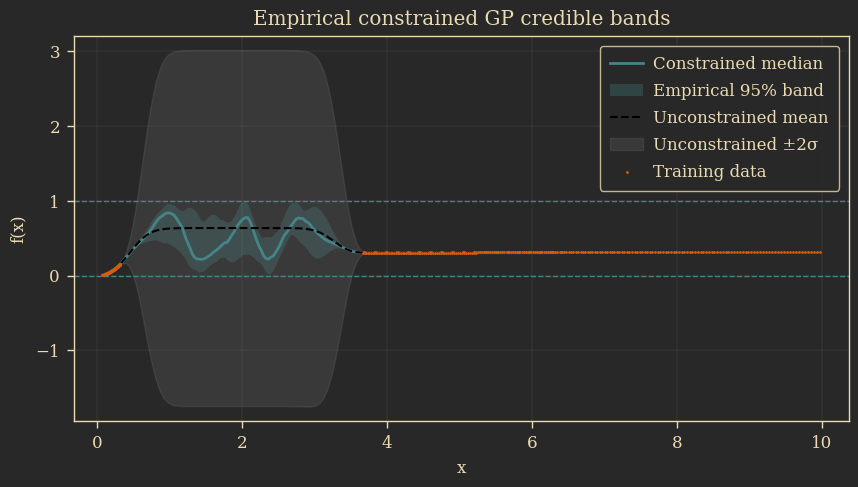

In [29]:
import matplotlib.pyplot as plt

x_test_1d = np.ravel(n_test)
x_train_1d = np.ravel(n)

plt.figure(figsize=(10,5))
plt.plot(x_test_1d, q_median, '-', lw=2, label='Constrained median')
plt.fill_between(x_test_1d, q_lower, q_upper, alpha=0.3, label='Empirical 95% band')

# Unconstrained GP for comparison
mu_uncon = gp.mean_star.ravel()
sig_uncon = np.sqrt(np.clip(np.diag(gp.cov_star), 0, np.inf))
plt.plot(x_test_1d, mu_uncon, 'k--', lw=1.5, label='Unconstrained mean')
plt.fill_between(x_test_1d,
                 mu_uncon - 2*sig_uncon,
                 mu_uncon + 2*sig_uncon,
                 color='gray', alpha=0.2, label='Unconstrained ±2σ')

# Training data and bounds
plt.scatter(x_train_1d, cs2, s=1, zorder=3, label='Training data')
plt.axhline(0, ls='--', lw=1)
plt.axhline(1, ls='--', lw=1)
plt.xlabel("x"); plt.ylabel("f(x)")
plt.title("Empirical constrained GP credible bands")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


## integral bounds

In [30]:
import numpy as np

def build_C_trap(Xc, n0, n_mu):
    """
    Xc: sorted (N_c,) grid for cs2
    n0: scalar lower limit
    n_mu: (M,) points where mu-bounds are specified

    Returns C: (M, N_c) such that (C @ y_c)[i] ≈ ∫_{n0}^{n_mu[i]} cs2(u)/u du
    """
    X = np.asarray(Xc).ravel()
    M = len(n_mu)
    Nc = len(X)
    C = np.zeros((M, Nc))

    # ensure n0 inside grid range
    if not (X[0] <= n0 <= X[-1]):
        raise ValueError("n0 must lie within the constraint grid Xc range.")

    # indices to start integration
    # find j0 so that X[j0] <= n0 <= X[j0+1]
    j0 = np.searchsorted(X, n0) - 1
    j0 = np.clip(j0, 0, Nc-2)

    # precompute segment widths and 1/x factors
    dx = np.diff(X)
    invX = 1.0 / X

    for i, n_target in enumerate(n_mu):
        if n_target < n0:
            continue  # integral is zero if target before n0
        # find k so that X[k] <= n_target <= X[k+1]
        k = np.searchsorted(X, n_target) - 1
        k = np.clip(k, 0, Nc-2)

        # full segments from max(j0,0) .. k-1
        j_start = j0
        if n0 > X[j0]:  # partial first cell [n0, X[j0+1]]
            # weight only on nodes j0 and j0+1 for the partial length
            L = X[j0+1] - n0
            # trapezoid on cs2/x over partial length
            C[i, j0  ] += 0.5 * L * invX[j0]
            C[i, j0+1] += 0.5 * L * (1.0 / X[j0+1])
            j_start = j0+1
        # full cells
        for j in range(j_start, k):
            L = dx[j]
            C[i, j  ] += 0.5 * L * invX[j]
            C[i, j+1] += 0.5 * L * (1.0 / X[j+1])

        # partial last cell [X[k], n_target]
        if n_target > X[k]:
            L = n_target - X[k]
            C[i, k  ] += 0.5 * L * invX[k]
            C[i, k+1] += 0.5 * L * (1.0 / X[k+1])

    return C


In [31]:
e0, p0,n0, mu0 = anal.get_ceft_ini()

In [32]:
Xc_int = np.linspace(n[0], n[-1], 400)

In [33]:
n_pqcd_ns = n_pqcd*ns

In [34]:
C = build_C_trap(Xc_int, n0, (n_pqcd_ns))

In [35]:
a_mu_interp = np.interp(n_pqcd_ns, n_pqcd_grid, mu_min)
b_mu_interp = np.interp(n_pqcd_ns, n_pqcd_grid, mu_max)

a_mu = np.log(a_mu_interp / mu0)
    
b_mu = np.log(b_mu_interp / mu0)


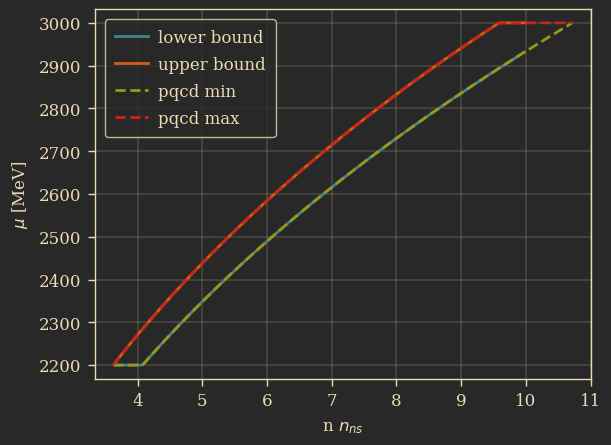

In [36]:
plt.plot(n_pqcd_ns, a_mu_interp, label='lower bound')
plt.plot(n_pqcd_ns, b_mu_interp, label='upper bound')
plt.plot(n_pqcd_grid, mu_min, '--', label='pqcd min')
plt.plot(n_pqcd_grid, mu_max, '--', label='pqcd max')
plt.xlabel(r"n $n_{ns}$")
plt.ylabel(r"$\mu$ [MeV]")
plt.legend()
plt.show()

In [132]:
A_int = np.vstack([ C, -C ])
b_int = np.concatenate([-a_mu, b_mu])


In [133]:
X_c = np.linspace(n[0], n[-1], 400)  # for prototyping, uniform grid
a = np.zeros(len(X_c))     # lower bound 0
b = np.ones(len(X_c))      # upper bound 1
d = len(X_c)
A_bounds = np.vstack([np.eye(d), -np.eye(d)])
b_bounds = np.concatenate([-a, b])

In [134]:
A = np.vstack([A_bounds, A_int])
b = np.concatenate([b_bounds, b_int])

In [ ]:
# Step 1: gather constraint locations (discretization of I)
Xc_bounds = np.linspace(n_ceft[-1]*ns, n_pqcd[0]*ns, 100)   # uniform grid inside the gap

# Union grid that spans both constraint domains, *not* the training data
Xc_total = np.unique(np.concatenate([Xc_bounds, Xc_int]))
N_total = len(Xc_total)

# --- 1. Bounds constraints (only active on Xc_bounds)
# Build A_bounds embedded in total grid
idx_bounds = np.searchsorted(Xc_total, Xc_bounds)
A_bounds = np.zeros((2 * len(Xc_bounds), N_total))
for i, j in enumerate(idx_bounds):
    A_bounds[i, j] = 1.0
    A_bounds[i + len(Xc_bounds), j] = -1.0
b_bounds = np.concatenate([np.zeros(len(Xc_bounds)), np.ones(len(Xc_bounds))])

C_local = build_C_trap(Xc_total, n0=n0, n_mu=n_pqcd_ns)
A_int = np.vstack([C_local, -C_local])
b_int = np.concatenate([-a_mu, b_mu])

# --- 3. Stack them vertically

# Now both have N_total columns -> stack works
A = np.vstack([A_bounds, A_int])
b = np.concatenate([b_bounds, b_int])

In [135]:
# Step 2: compute GP posterior mean and cov at constraint points

mean_train, mean_c = gp._set_means(n, Xc_total)
K_11 = gp._set_K_11(n, stabilise=True)
K_1c = gp.kernel.compute(n, Xc_total)
K_cc = gp.kernel.compute(Xc_total)

f_tilde = cs2 - mean_train
L, alpha = gp._compute_cholesky(K_11, f_tilde)
v_c = solve_triangular(L, K_1c, lower=True)
Sigma_Z = K_cc - v_c.T @ v_c
mu_Z = mean_c + K_1c.T @ alpha


In [136]:
# covariance between test points and constraint points
K_1t, K_tc = gp.kernel.compute(n, n_test), gp.kernel.compute(n_test, Xc_total)
mean_train, mean_test = gp._set_means(n, n_test)

# conditional cross-covariance: k(x_*, X_c) - k(X_s, x_*)^T Σ_s^{-1} k(X_s, X_c), *: test, c: constraint, s:train
# k(X_s, x_*)^T Σ_s^{-1} k(X_s, X_c) = k(X_s, x_*)^T (L L^T)^{-1} k(X_s, X_c) = (L^{-1} k(X_s, x_*))^T (L^{-1} k(X_s, X_c))
v_t = solve_triangular(L, K_1t, lower=True, check_finite=False) # (L^{-1} k(X_s, x_*))^T 
v_c = solve_triangular(L, K_1c, lower=True, check_finite=False) #  (L^{-1} k(X_s, X_c))
K_tt = gp.kernel.compute(n_test)

Sigma_YZ = K_tc - v_t.T @ v_c   # Cov(Ỹ(x_*), Ỹ(X_c))

In [137]:
import tmg_samplers as tmg

Z_samples = tmg.sample_tmvn_ess(
    mu=mu_Z,
    cov=Sigma_Z,
    A=A,
    b=b,
    X=Xc_total,
    y=cs2,
    n_samples=50,
    burn_in=100,
    eta_init=20.0,
    update_eta=True
)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 200 is different from 400)

In [103]:
# compute truncated moments
nu_Z = np.mean(Z_samples, axis=0)
Gamma_Z = np.cov(Z_samples, rowvar=False)

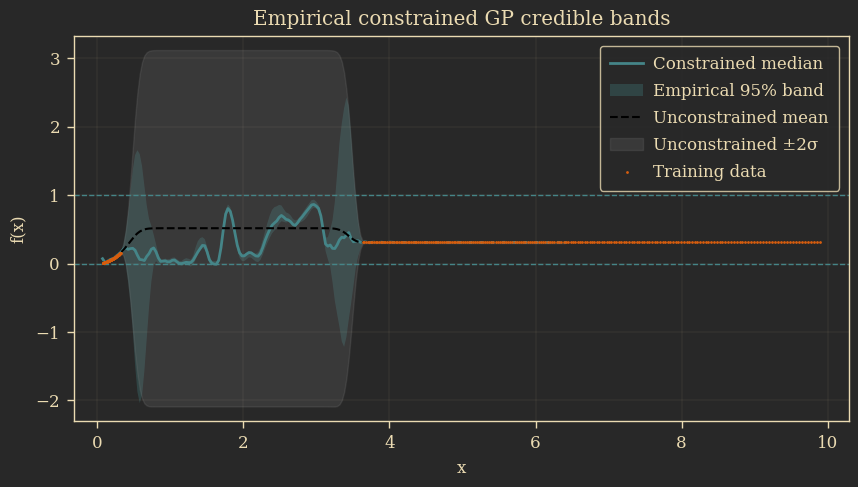

In [104]:
# Precompute Σ_Z^{-1} using a stable Cholesky solve
Lz = cholesky(Sigma_Z + 1e-10 * np.eye(Sigma_Z.shape[0]), lower=True)
inv_Sz = cho_solve((Lz, True), np.eye(Sigma_Z.shape[0]))

# Compute the constant conditional covariance (shared across samples)
S_star = gp.cov_star - Sigma_YZ @ inv_Sz @ Sigma_YZ.T
S_star = 0.5 * (S_star + S_star.T)  # symmetrize


# Generate conditional means for each Z sample
Z_centered = Z_samples - mu_Z        # (n_samples, n_c)
m_stars = gp.mean_star + (Sigma_YZ @ inv_Sz @ Z_centered.T).T  # (n_samples, n_t)

# add conditional Gaussian spread
from numpy.random import default_rng

rng = default_rng()

# Number of predictive points
n_t = S_star.shape[0]
n_samples = m_stars.shape[0]

# Draw Gaussian residuals with covariance S_star
eps = rng.multivariate_normal(
    mean=np.zeros(n_t),
    cov=S_star,
    size=n_samples,
    check_valid='ignore',  # skip SPD check (faster, can handle small negatives)
    tol=1e-6               # optional: tolerates slight non-PD covariances
)
Ystar_samples = m_stars + eps

q_lower, q_median, q_upper = np.quantile(Ystar_samples, [0.025, 0.5, 0.975], axis=0)


x_test_1d = np.ravel(n_test)
x_train_1d = np.ravel(n)

plt.figure(figsize=(10,5))
plt.plot(x_test_1d, q_median, '-', lw=2, label='Constrained median')
plt.fill_between(x_test_1d, q_lower, q_upper, alpha=0.3, label='Empirical 95% band')

# Unconstrained GP for comparison
mu_uncon = gp.mean_star.ravel()
sig_uncon = np.sqrt(np.clip(np.diag(gp.cov_star), 0, np.inf))
plt.plot(x_test_1d, mu_uncon, 'k--', lw=1.5, label='Unconstrained mean')
plt.fill_between(x_test_1d,
                 mu_uncon - 2*sig_uncon,
                 mu_uncon + 2*sig_uncon,
                 color='gray', alpha=0.2, label='Unconstrained ±2σ')

# Training data and bounds
plt.scatter(x_train_1d, cs2, s=1, zorder=3, label='Training data')
plt.axhline(0, ls='--', lw=1)
plt.axhline(1, ls='--', lw=1)
plt.xlabel("x"); plt.ylabel("f(x)")
plt.title("Empirical constrained GP credible bands")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


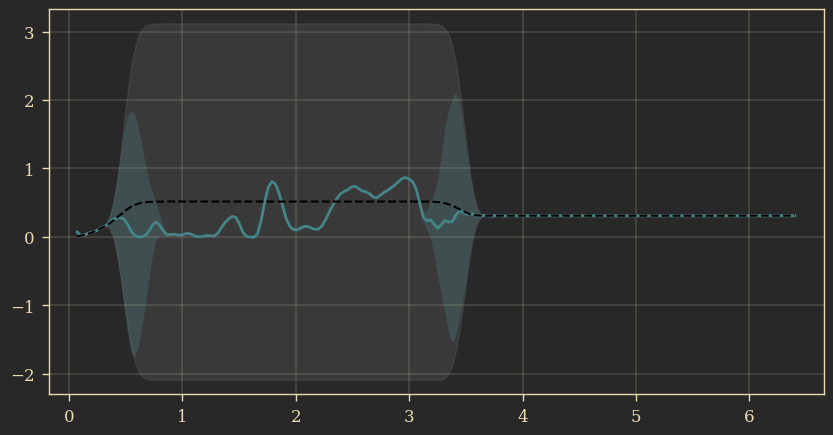

In [105]:
# Center: constrained mean curve (use mean or median of m_stars)
mu_con = m_stars.mean(axis=0)   # shape (n_t,)
# mu_con = np.median(m_stars, axis=0)  # alternative

# Use S_* only
S_star = 0.5 * (S_star + S_star.T)            # symmetrize
var_S  = np.clip(np.diag(S_star), 0.0, np.inf)
sd_S   = np.sqrt(var_S)

# e.g., 95% Gaussian band from S_* only
z = 1.96
lower_Sonly = mu_con - z * sd_S
upper_Sonly = mu_con + z * sd_S


plt.figure(figsize=(10,5))
plt.plot(x_test_1d, mu_con, '-', lw=2, label='Constrained mean')
plt.fill_between(x_test_1d, lower_Sonly, upper_Sonly, alpha=0.3, label='Gaussian 95% band (S_*)')
# Unconstrained GP for comparison
mu_uncon = gp.mean_star.ravel()
sig_uncon = np.sqrt(np.clip(np.diag(gp.cov_star), 0, np.inf))
plt.plot(x_test_1d, mu_uncon, 'k--', lw=1.5, label='Unconstrained mean')
plt.fill_between(x_test_1d,
                 mu_uncon - 2*sig_uncon,
                 mu_uncon + 2*sig_uncon,
                 color='gray', alpha=0.2, label='Unconstrained ±2σ')
plt.show()

In [106]:
eos = EosProperties(n = n_test, phi=None, epsi_0=e0, p_0=p0, mu_0=mu0, cs2 = q_median)

In [107]:
vals = eos.get_all()

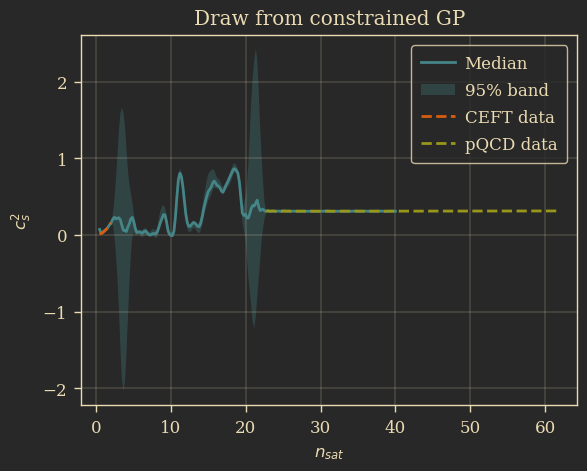

In [108]:
plt.plot(n_test/ns, vals["cs2"], label='Median')
plt.fill_between(n_test/ns, q_lower, q_upper, alpha=0.3, label='95% band')
plt.plot(n_ceft, cs2_ceft, '--', label='CEFT data')
plt.plot(n_pqcd, cs2_pqcd, '--', label='pQCD data')
plt.xlabel(r"$n_{sat}$")
plt.ylabel(r"$c_s^2$")
plt.title("Draw from constrained GP")
plt.legend()
plt.show()

In [10]:
n_ceft, mu_ceft, mu_ch_lower, mu_ch_upper = anal.get_ceft("mu")

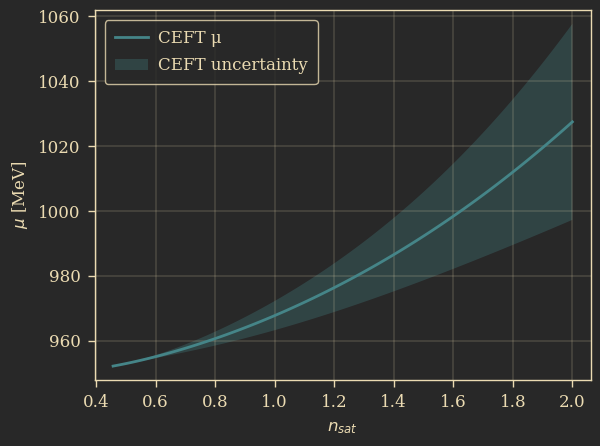

In [13]:
plt.plot(n_ceft, mu_ceft, label='CEFT μ')
plt.fill_between(n_ceft, mu_ch_lower, mu_ch_upper, alpha=0.3, label='CEFT uncertainty')
plt.xlabel(r"$n_{sat}$")
plt.ylabel(r"$\mu$ [MeV]")
plt.legend()

In [11]:
plt.plot(n_test/ns, np.log(vals["mu"]), label='Constrained GP EoS median')
plt.fill_between(n_pqcd_grid/ns, np.log(mu_min), np.log(mu_max), color='orange', alpha=0.3, label='pQCD band')
plt.plot(n_ceft, np.log(mu_ceft), '--', label='CEFT data')
plt.xlabel(r"n $n_{ns}$")
plt.ylabel(r"log $\mu$ (MeV)")
plt.title("Chemical potential with pQCD constraints")
plt.legend()
plt.show()

NameError: name 'n_test' is not defined

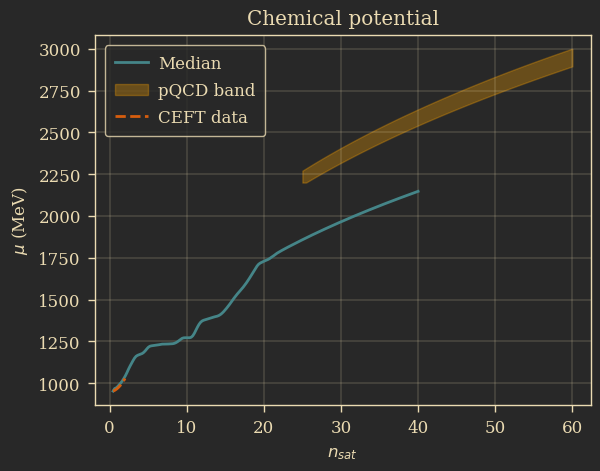

In [111]:
plt.plot(n_test/ns, vals["mu"], label='Median')
plt.fill_between(n_pqcd_grid/ns, mu_min, mu_max, color='orange', alpha=0.3, label='pQCD band')
plt.plot(n_ceft, mu_ceft, '--', label='CEFT data')
plt.xlabel(r"$n_{sat}$")
plt.ylabel(r"$\mu$ (MeV)")
plt.title("Chemical potential")
plt.legend()
plt.show()

Text(0.5, 1.0, 'leverage λ(x)')

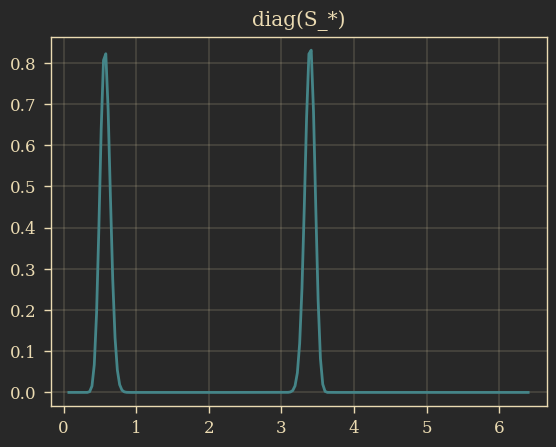

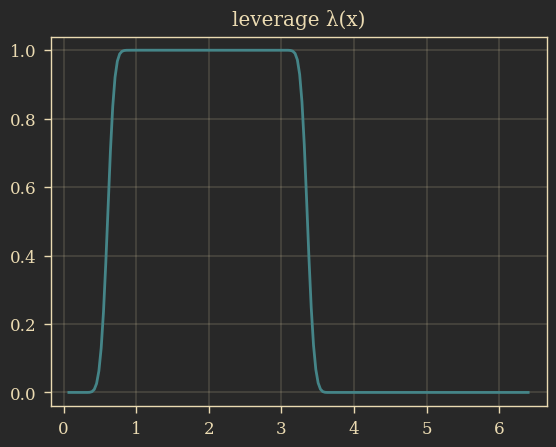

In [112]:
var_star = np.diag(S_star)
lev = np.einsum('ti,ij,jt->t', Sigma_YZ, inv_Sz, Sigma_YZ.T) / np.diag(gp.cov_star)
plt.plot(n_test, var_star); plt.title('diag(S_*)')
plt.figure(); plt.plot(n_test, lev); plt.title('leverage λ(x)')


### softmax and its approximation

In [27]:
x = np.linspace(-300000, 300000, 100)
y1 = np.log1p(np.exp(x))
y2 = np.log1p(np.exp(-np.abs(x))) + np.maximum(0,x)

/tmp/ipykernel_93318/1723838332.py:2: RuntimeWarning: overflow encountered in exp
  y1 = np.log1p(np.exp(x))


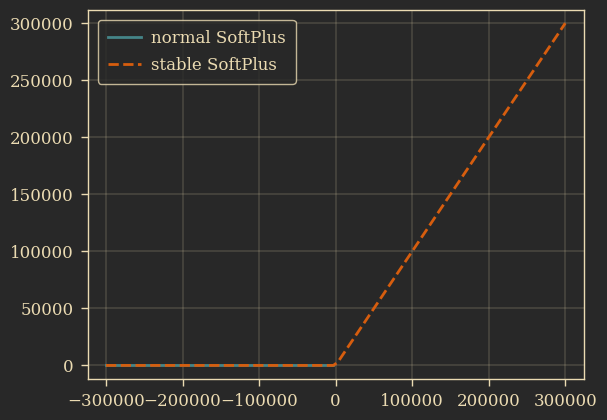

In [29]:
plt.plot(x, y1, label='normal SoftPlus')
plt.plot(x, y2, '--' , label='stable SoftPlus')
plt.legend()
plt.show()